In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder , OrdinalEncoder
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


In [135]:
df = pd.read_csv("Heart.csv")

In [136]:
df.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,Target
0,63,1,typical,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2,reversable,1
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0,normal,0


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        303 non-null    int64  
 1   Sex        303 non-null    int64  
 2   ChestPain  303 non-null    object 
 3   RestBP     303 non-null    int64  
 4   Chol       303 non-null    int64  
 5   Fbs        303 non-null    int64  
 6   RestECG    303 non-null    int64  
 7   MaxHR      303 non-null    int64  
 8   ExAng      303 non-null    int64  
 9   Oldpeak    303 non-null    float64
 10  Slope      303 non-null    int64  
 11  Ca         303 non-null    int64  
 12  Thal       301 non-null    object 
 13  Target     303 non-null    int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 33.3+ KB


## Cleaning Data

In [138]:
df = df.dropna()

In [139]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
numeric_cols = numeric_df.columns 

for col in numeric_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    df[col] = np.clip(df[col], lower_limit, upper_limit)

## Handling Categorical Data 

In [53]:
print(df['ChestPain'].unique())
print(df['Thal'].unique())

['typical' 'asymptomatic' 'nonanginal' 'nontypical']
['fixed' 'normal' 'reversable']


### Which Encoding types should I use?

    In our dataset we can see that Thal , RestECG, Slope , Ca and ChestPain columns are categorical columns. Even though some of them can look like numerical. (like RestECG, Slope , Ca) They doesn't have meanings like numerical columns. We have to encode them. 

1. For Thal - RestECG - Chestpain I'm gonna use one_hot and label for different models.
2. Slope has a real order. So I'm gonna use ordinal encoding (with both of the dataset)

In [54]:
df_one_hot = pd.get_dummies(df , columns = ["Thal", "RestECG" , "ChestPain"] , dtype = int)
df_one_hot.head(3)

,Age,Sex,RestBP,Chol,Fbs,MaxHR,ExAng,Oldpeak,Slope,Ca,...,Thal_fixed,Thal_normal,Thal_reversable,RestECG_0,RestECG_1,RestECG_2,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical
0,63,1,145,233,0,150,0,2.3,3,0.0,...,1,0,0,0,0,1,0,0,0,1
1,67,1,160,286,0,108,1,1.5,2,2.5,...,0,1,0,0,0,1,1,0,0,0
2,67,1,120,229,0,129,1,2.6,2,2.0,...,0,0,1,0,0,1,1,0,0,0


In [55]:
le = LabelEncoder()
df_label = df.copy()

for col in ["Thal" , "RestECG" , "ChestPain" ]:
    df_label[col] = le.fit_transform(df[col])

df_label.head(3)

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,Target
0,63,1,3,145,233,0,2,150,0,2.3,3,0.0,0,0
1,67,1,0,160,286,0,2,108,1,1.5,2,2.5,1,1
2,67,1,0,120,229,0,2,129,1,2.6,2,2.0,2,1


In [67]:
ordinal_encoder = OrdinalEncoder()
datasets = {
    "label": df_label,
    "onehot": df_one_hot
}
for name in datasets:
    datasets[name]['Slope'] = ordinal_encoder.fit_transform(datasets[name][['Slope']])

    Right now, we have two different datasets. We are going to split both of them into training and test sets to train our model.

## Spliting Datasets

In [68]:
splits = {}
for name, data in datasets.items():

    X = data.drop("Target", axis=1)
    y = data["Target"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=111 if name=="label" else 100
    )

    splits[name] = {
        "X_train": X_train.copy(),
        "X_test": X_test.copy(),
        "y_train": y_train,
        "y_test": y_test
    }

## Feature Scaling

In [69]:
continuous_cols = ['Age', 'RestBP', 'Chol', 'MaxHR', 'Oldpeak']

standard = StandardScaler()
minmax = MinMaxScaler()

for name, data in splits.items():
    scaler = standard if name == "label" else minmax
    
    data["X_train"][continuous_cols] = scaler.fit_transform(data["X_train"][continuous_cols])
    data["X_test"][continuous_cols] = scaler.transform(data["X_test"][continuous_cols])

## Training and Evaluating Models

For evaluating and training we can create a functions because we are going to do the same thing over and over again. It would be waste of time if we don't use functions

In [118]:
def fit_data( splits , label_model , onehot_model):
    for name , data in splits.items() :
        lr = label_model if name == "label" else onehot_model 
        lr.fit(data["X_train"] , data["y_train"])

def evaluate_model(name ,model, X_test, y_test):
    y_pred = model.predict(X_test)

    print(f"{name} dataset :")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:\n", cm)
    
    y_proba = model.predict_proba(X_test)[:, 1]
    print("\nROC-AUC:", roc_auc_score(y_test, y_proba))

def evaluate_data( splits , label_model , onehot_model ) :
    for name , data in splits.items() :
        lr = label_model if name == "label" else onehot_model
        evaluate_model(name , lr, data["X_test"] , data["y_test"])
        print("--------------------------------------------------------------")


### 1. Logicstic Regression

First of all we have to fit our data for our model using train sets.

In [119]:
label_lr = LogisticRegression(max_iter=1000)
onehot_lr = LogisticRegression(max_iter=1000, solver='liblinear')

fit_data(splits , label_lr , onehot_lr )
evaluate_data(splits , label_lr , onehot_lr)

label dataset :
Accuracy: 0.8032786885245902

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.78      0.82        36
           1       0.72      0.84      0.78        25

    accuracy                           0.80        61
   macro avg       0.80      0.81      0.80        61
weighted avg       0.81      0.80      0.80        61


Confusion Matrix:
 [[28  8]
 [ 4 21]]

ROC-AUC: 0.9233333333333333
--------------------------------------------------------------
onehot dataset :
Accuracy: 0.8524590163934426

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.97      0.87        30
           1       0.96      0.74      0.84        31

    accuracy                           0.85        61
   macro avg       0.87      0.85      0.85        61
weighted avg       0.87      0.85      0.85        61


Confusion Matrix:
 [[29  1]
 [ 8 23]]

ROC-AUC: 0.9344086021505377
------

## 2. Decision Tree

In [120]:
label_dt= DecisionTreeClassifier()
onehot_dt = DecisionTreeClassifier()

fit_data(splits , label_dt , onehot_dt )
evaluate_data(splits , label_dt , onehot_dt)

label dataset :
Accuracy: 0.819672131147541

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.78      0.84        36
           1       0.73      0.88      0.80        25

    accuracy                           0.82        61
   macro avg       0.82      0.83      0.82        61
weighted avg       0.83      0.82      0.82        61


Confusion Matrix:
 [[28  8]
 [ 3 22]]

ROC-AUC: 0.8288888888888888
--------------------------------------------------------------
onehot dataset :
Accuracy: 0.6721311475409836

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.73      0.69        30
           1       0.70      0.61      0.66        31

    accuracy                           0.67        61
   macro avg       0.68      0.67      0.67        61
weighted avg       0.68      0.67      0.67        61


Confusion Matrix:
 [[22  8]
 [12 19]]

ROC-AUC: 0.6731182795698925
-------

## 3. Support Vector Machine

In [121]:
label_svm = SVC(probability = True)
onehot_svm = SVC(probability = True)

fit_data(splits , label_svm, onehot_svm )
evaluate_data(splits , label_svm , onehot_svm)

label dataset :
Accuracy: 0.8032786885245902

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83        36
           1       0.76      0.76      0.76        25

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61


Confusion Matrix:
 [[30  6]
 [ 6 19]]

ROC-AUC: 0.9155555555555555
--------------------------------------------------------------
onehot dataset :
Accuracy: 0.7704918032786885

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.87      0.79        30
           1       0.84      0.68      0.75        31

    accuracy                           0.77        61
   macro avg       0.78      0.77      0.77        61
weighted avg       0.78      0.77      0.77        61


Confusion Matrix:
 [[26  4]
 [10 21]]

ROC-AUC: 0.8956989247311828
------

## 4. Random Forest Classifier 

In [122]:
label_rfc = RandomForestClassifier()
onehot_rfc = RandomForestClassifier()

fit_data(splits , label_rfc , onehot_rfc )
evaluate_data(splits , label_rfc , onehot_rfc)

label dataset :
Accuracy: 0.8688524590163934

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.89        36
           1       0.81      0.88      0.85        25

    accuracy                           0.87        61
   macro avg       0.86      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61


Confusion Matrix:
 [[31  5]
 [ 3 22]]

ROC-AUC: 0.9233333333333333
--------------------------------------------------------------
onehot dataset :
Accuracy: 0.7868852459016393

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.90      0.81        30
           1       0.88      0.68      0.76        31

    accuracy                           0.79        61
   macro avg       0.80      0.79      0.78        61
weighted avg       0.80      0.79      0.78        61


Confusion Matrix:
 [[27  3]
 [10 21]]

ROC-AUC: 0.8946236559139785
------

## THE RESULTS

The best performance models are Random Forest with label dataset.

## Hyperparameter Tuning 

First we have to select the random forest parameters. Then we will use these parameters to find the best parameters for the Random Forest model.

In [127]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

In [128]:
RandomForestGrid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

RandomForestGrid.fit(splits["label"]["X_train"], splits["label"]["y_train"])
print(grid.best_params_)

{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [129]:
best_model = RandomForestGrid.best_estimator_
evaluate_model("Tuned_Random_Forest", best_model , splits["label"]["X_test"] ,  splits["label"]["y_test"])

Tuned_Random_Forest dataset :
Accuracy: 0.9016393442622951

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92        36
           1       0.88      0.88      0.88        25

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61


Confusion Matrix:
 [[33  3]
 [ 3 22]]

ROC-AUC: 0.9355555555555556


The recall and ROC-AUC score rises with the parameter we find using GridSearchCV.

## Feature Importance

In [131]:
importance_df = pd.DataFrame({
    "feature": splits["label"]["X_train"].columns,
    "importance": best_model.feature_importances_
}).sort_values("importance", ascending=False)

print(importance_df.head(10))


      feature  importance
7       MaxHR    0.149618
2   ChestPain    0.147058
11         Ca    0.146668
12       Thal    0.126792
9     Oldpeak    0.108934
8       ExAng    0.081298
0         Age    0.071991
4        Chol    0.045111
3      RestBP    0.045028
10      Slope    0.034708


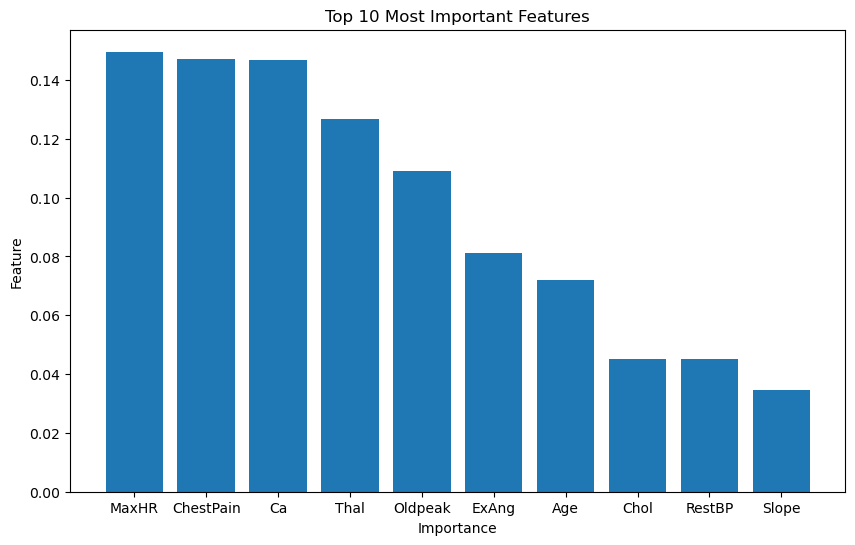

In [142]:
top_features = importance_df.head(10)

plt.figure(figsize=(10,6))
plt.bar(top_features["feature"], top_features["importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features")
plt.show()
